```text
SPDX-License-Identifier: PolyForm-Noncommercial-1.0.0
Autor: Bruno Francisco Barra Atarama
Institución:
  Departamento de Ingeniería Aeroespacial
  Facultad de Ingeniería
  Universidad Nacional de La Plata
Año: 2025
Licencia: PolyForm Noncommercial License 1.0.0
```

**Licencia:** ver [LICENSE](../LICENSE).

# Ejemplo: cinemática aeroelástica

En este ejemplo se muestra cómo configurar un conjunto de sólidos para simular experimentos donde las cinemáticas no estén prescritas y puedan utilizar información del último instante resuelto por el simulador, así como el resto de variables almacenadas en una instancia de `MP2D`.

El ejemplo muestra el equivalente a una cinemática prescrita de rotación armónica, pero la extensión a un experimento aeroelástico real es directa. Incluso pueden idearse otros usos para este modo de operación.

## Bibliotecas y módulos

A continuación, se muestra qué bibliotecas se importan para este ejemplo particular.

El módulo de tipado se recomienda utilizar para aprovechar las ayudas documentadas, sobre todo en los primeros usos.

In [1]:
%matplotlib inline
# Para gráficos interactivos en el notebook. # Para utilizar, instalar ipympl con `pip install ipympl`
# %matplotlib widget    

# Bibliotecas generales
import numpy as np
import matplotlib.pyplot as plt

# Módulos propios

# Funcionales
from src.MP2D import MP2D
from src import Cinematicas
from src.Importacion import discretizarPerfil

# Tipado
from src import Tipos

## Parámetros de la cinemática interna

Aquí lo que se definirá no es precisamente lo aeroelástico, simplemente es la configuración de una cinemática que será manipulada por las funciones aeroelásticas para poder computar una cinemática. En un caso aeroelástico real esto no formaría parte del esquema.

Lo definido aquí, podría encontrarse definido dentro de las funciones aeroelásticas, pero se lo define antes para que sea accesible tanto por la función aeroelástica de la cinemática como la del vector de toma de momentos.

In [2]:
# Importación y discretización del perfil.
c = 2
NIntraExtra = 60
r_xy = discretizarPerfil('rec/perfiles/NACA23012_selig.txt', NIntraExtra, NIntraExtra, c, 'selig')

# Parámetros de la cinemática de rotación armónica.
V = 100
a0 = 5
w = 2 * np.pi * 3

dt = 0.001      # Paso de tiempo a utilizar.

## Funciones aeroelásticas

Denominadas `actualizadores` en la documentación, su propósito es ser llamadas en cada nuevo instante de simulación por el método de resolución para obtener la cinemática en el nuevo instante. 

A su vez, estas funciones reciben la instancia de simulación, por lo que estas pueden acceder a cualquier variable almacenada en esta, con el fin de poder realizar los cálculos necesarios, dinámicos por ejemplo.

In [3]:
actualizadorCinematica: Tipos.ActualizadorCinematica    # En la documentación (hover sobre el tipo) se puede acceder a más información.
actualizadorRM: Tipos.ActualizadorRM                    # En la documentación (hover sobre el tipo) se puede acceder a más información.

def actualizadorCinematicaFun(
        mp: MP2D | None,
        iS: int | None,
        it: int | None,
) -> Tipos.CinematicaSalida:
    
    if mp is not None:  # En el caso de estar efectivamente en un instante de resolución.
        # Se define la cinemática de rotación armónica.
        
        _t = dt * it     # Instante de simulación. Podría definirse con otra ley utilizando el número de iteración u otro parámetro. 
        
        _VO = - np.array([[V], [0]]) 

        _RO = _VO * _t
        

        _thetaMax = -np.deg2rad(a0)

        _theta = _thetaMax * np.sin(w * _t)
        _w = _thetaMax * w * np.cos(w * _t)

        _VRelPC_xy = np.zeros((2, r_xy.shape[1] - 1))

        return _t, _RO, _theta, _VO, _w, r_xy, _VRelPC_xy
    
    else:               # Esto puede omitirse ya que es el comportamiento normal de las funciones de Python pero se la deja con fines clarificadores.
        return None     # Esto es utilizado en la purga del generador antes de comenzar la resolución. 
    
def actualizadorRMFun(
        mp: MP2D | None,
        it: int | None,
) -> Tipos.CinematicaSalida:
    
    if mp is not None:  # En el caso de estar efectivamente en un instante de resolución.
        # Como la función aeroelástica del momento es invocada durante un instante de resolución, no todas las litas temporales
        # tienen el mismo grado de completitud.
        # A grosso modo, las cinemáticas de los sólidos y las estelas sí están resueltas en el último instante,
        # mientras que las presiones, fuerzas y momentos, no.

        # El punto de toma de momentos se obtiene directamente de la instancia MP2D como el borde de ataque del perfil
        # en el último instante.
        RM = np.array([mp.conjuntos[-1].solidos[0].r_xy[:, NIntraExtra + 1]]).T
        return RM
    
    else:               # Esto puede omitirse ya que es el comportamiento normal de las funciones de Python pero se la deja con fines clarificadores.
        return None     # Esto es utilizado en la purga del generador antes de comenzar la resolución. 

## Obtención de los generadores y simulación

Simulando: 100%|██████████| 100/100 [00:00<00:00, 190.80 pasos/s]


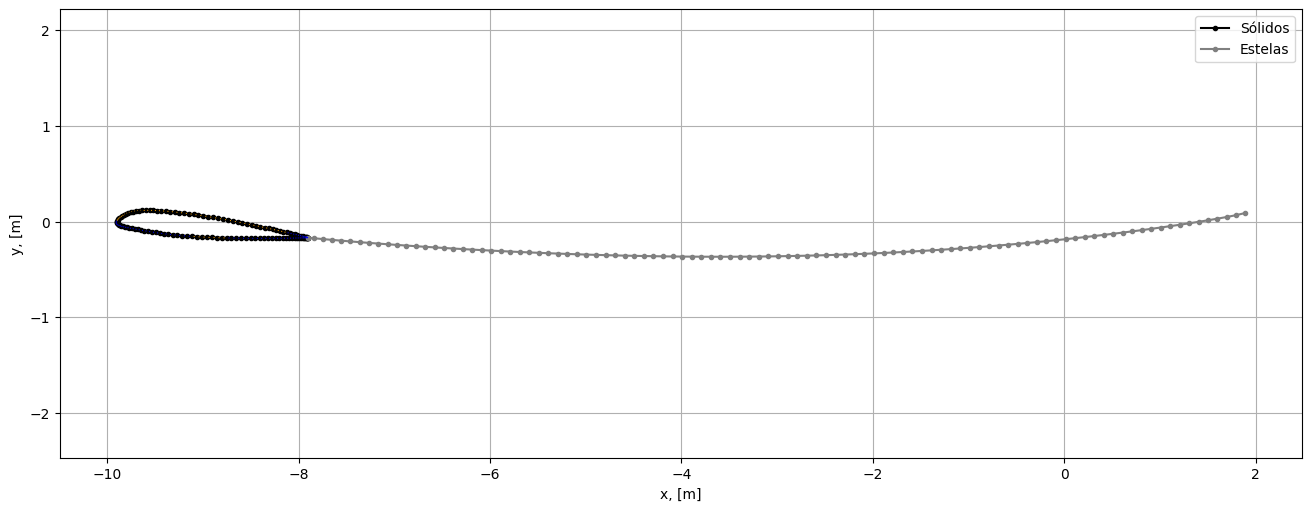

In [4]:
# Se asignan las funciones a variables (puede omitirse y pasarlas directamente como values del diccionario de configuración)
actualizadorCinematica = actualizadorCinematicaFun
actualizadorRM = actualizadorRMFun

# Se contruyen los diccionarios de configuración de las cinemáticas aeroelásticas.
aeroelasticidadParams: Tipos.AeroelasticidadParams = {'actualizadorCinematica' : actualizadorCinematica}
RMAeroelasticidadParams: Tipos.RMAeroelasticidadParams = {'actualizadorRM' : actualizadorRM}

# Se obtienen los generadores
cinematicas = [Cinematicas.cinematica('aeroelasticidad', aeroelasticidadParams)]
RM = Cinematicas.RM('aeroelasticidad', RMAeroelasticidadParams)

# Se configura el simulador en modo aeroelástico.
mpConfig: Tipos.MPConfig = {
    'aeroelasticidad' : True,
    'RMAeroelasticidad' : True,
}

# Condiciones de referencia
refConfig: Tipos.RefConfig = {'l' : c, 'V': V}

# Se instancia el simulador
mp = MP2D(cinematicas, RM, mpConfig, refConfig)

mp.simular(100)

fig, ax = plt.subplots(1, 1, figsize=(13, 5), constrained_layout=True)
ax = mp.plotCpVect(it=-1, ax=ax, escala=0.01)
plt.show()